In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.linalg import qr
from numpy.random import random, RandomState
from scipy.sparse import csc_matrix

In [31]:

def err_svd(svdfunc, N1, N2, P, n, M, rseed=0, args=None, matfunc=np.asarray, **kwargs):
    if args is None:
        args = ()   
    S_base = 10.**np.arange(1,-n+1,-1)
    err_svd = np.zeros((M,len(P)))
    rng = RandomState(rseed)
    for i in range(M):
        U,_ = qr(rng.rand(N1, n))
        V,_ = qr(rng.rand(N2, n))
        for j,p in enumerate(P):
            S = S_base**p
            A = matfunc(np.dot(U,(S*V).T))
            try:
                u,s,v = svdfunc(A,*args,**kwargs)
            except:
                print A.todense()
                raise
            if len(s) < len(S):
                s = np.pad(s,len(S)-len(s),'constant', constant_values=0)
            s = np.sort(s)[:-(n+1):-1]
            try:
                err_svd[i,j] = np.linalg.norm(S-s)
            except:
                print n,s
                raise
    return err_svd


def compute_propack(N1, N2, P, n, M, rseed=0):
    from pypropack import svdp
    print "computing svd error for propack..."
    return err_svd(svdp, N1, N2, P, n, M, k=n, kmax=N2, rseed=rseed,
                 matfunc=csc_matrix)

def compute_arpack(N1, N2, P, n, M, rseed=0):
    from scipy.sparse.linalg import svds
    print "computing svd error for arpack..."
    return err_svd(svds, N1, N2, P, n, M, k=n, rseed=rseed, matfunc=csc_matrix)

def compute_svdlibc(N1, N2, P, n, M, rseed=0):
    from sparsesvd import sparsesvd
    print "computing svd error for svdlibc..."
    return err_svd(sparsesvd, N1, N2, P, n, M, args=(n,), rseed=rseed, matfunc=csc_matrix)

def compute_lapack(N1, N2, P, n, M, rseed=0):
    from scipy.linalg import svd
    print "computing svd error for lapack..."
    return err_svd(svd, N1, N2, P, n, M, rseed=rseed, full_matrices=False)

In [34]:
P = np.arange(.25,16,.25)
n = 4
M = 100
N1 = 25
N2 = 10
rseed = 1

SVDs = {
    'propack' : compute_propack,
    'arpack'  : compute_arpack,
#     'svdlibc' : compute_svdlibc,
    'lapack'  : compute_lapack
}

svd_err = {}
for name, compute_func in SVDs.items():
    svd_err[name] =  compute_func(N1,N2,P,n,M,rseed=rseed)

computing svd error for lapack...
computing svd error for arpack...
computing svd error for propack...


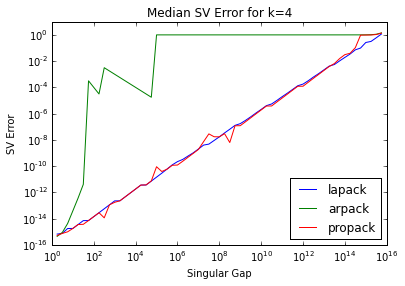

In [36]:
fig, ax = plt.subplots(subplot_kw=dict(xscale='log', yscale='log'))

for name, err in svd_err.items():
    ax.plot(10**K,np.median(err,axis=0),label=name)

ax.legend(loc=4);
ax.set_xlabel('Singular Gap');
ax.set_ylabel('SV Error');
ax.set_title('Median SV Error for k={0}'.format(n));
